In [1]:
dataset_path = '/content/iot_traffic_log.csv'


In [2]:


import pandas as pd
df = pd.read_csv(dataset_path)
print(df.head())


      timestamp event_source   client_id                                topic  \
0  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   
1  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   
2  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   
3  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   
4  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   

   qos  retain  payload_size  payload_is_json  payload_has_temp_hum_keys  \
0    0   False            93             True                       True   
1    0   False            93             True                       True   
2    0   False            93             True                       True   
3    0   False            92             True                       True   
4    0   False            93             True                       True   

   msg_rate_in_window attack_label  \
0                 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns



# --- 1. Load the dataset ---
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully. Head:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{dataset_path}' was not found.")
    print("Please make sure the dataset_path variable points to your CSV file.")
    exit() # Exit the script if the file isn't found

# --- 2. Preprocessing ---

# Identify features and target
# We'll use numerical and boolean features, excluding high-cardinality/string columns
features = ['timestamp', 'payload_size', 'payload_is_json', 'payload_has_temp_hum_keys', 'msg_rate_in_window', 'qos', 'retain']
target = 'attack_label'

X = df[features]
y = df[target]

# Convert boolean columns to numeric (0 or 1) before defining transformers
for col in ['payload_is_json', 'payload_has_temp_hum_keys', 'retain']:
    X[col] = X[col].astype(int)

# Define numerical features for scaling
numerical_features_to_scale = ['timestamp', 'payload_size', 'msg_rate_in_window', 'qos', 'payload_is_json', 'payload_has_temp_hum_keys', 'retain']

# Create preprocessing pipelines for numerical features
numerical_transformer = StandardScaler()

# Create a column transformer to apply scaling to numerical features
# We are transforming all selected features in this case.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_to_scale)
    ]
)

# Apply preprocessing to features
X_processed_array = preprocessor.fit_transform(X)

# Get the names of the processed features
processed_feature_names = numerical_features_to_scale # Names are the same after scaling

# Convert the processed features array back to a DataFrame
X_processed_df = pd.DataFrame(X_processed_array, columns=processed_feature_names)

# Encode the target variable ('attack_label') using One-Hot Encoding
# Fit on the whole target variable to ensure all classes are captured
onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded_array = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

# Get the names of the encoded target variable columns
encoded_target_names = onehot_encoder.get_feature_names_out([target])

# Convert the encoded target variable to a DataFrame
y_encoded_df = pd.DataFrame(y_encoded_array, columns=encoded_target_names)

print("\nPreprocessing complete. Processed features shape:", X_processed_df.shape)
print("Encoded target shape:", y_encoded_df.shape)
print("Head of processed features:")
print(X_processed_df.head())
print("\nHead of encoded target:")
print(y_encoded_df.head())

# --- 3. Split Data ---
# Split into training and testing sets
# Stratify by the original target variable to maintain class distribution
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X_processed_df, y_encoded_df, test_size=0.2, random_state=42, stratify=y # Stratify using original y for correct distribution
)

# We also need the original, unencoded y_test for classification_report
_, _, _, y_test_original = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42, stratify=y
)


print("\nData splitting complete.")
print(f"X_train shape: {X_train.shape}, y_train_encoded shape: {y_train_encoded.shape}")
print(f"X_test shape: {X_test.shape}, y_test_encoded shape: {y_test_encoded.shape}")


# --- 4. Train and Evaluate Models ---

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # For models that expect multi-label target (like some scikit-learn classifiers
    # when used with one-hot encoding for multi-class), train on the encoded target.
    # However, for classification_report, we need the original labels.
    # Many scikit-learn classifiers directly support multi-class target with
    # integer or string labels. Let's train on the *original* y_train for simplicity
    # with models that support it, and then use the encoded y_test for comparison if needed,
    # but classification_report works best with original labels.

    # Let's re-split to get y_train and y_test in original format for training and evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed_df, y, test_size=0.2, random_state=42, stratify=y
    )


    model.fit(X_train, y_train)

    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)

    # Get evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results[model_name] = {
        'accuracy': accuracy,
        'report': report,
        'f1_score_macro': report['macro avg']['f1-score'] # Use macro average F1-score
    }

    print(f"--- {model_name} Results ---")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * (len(model_name) + 14))


# --- 5. Compare and Plot Results ---

print("\n--- Model Comparison ---")

# Create a DataFrame for easier comparison
comparison_df = pd.DataFrame({
    name: {'Accuracy': res['accuracy'], 'Macro F1-Score': res['f1_score_macro']}
    for name, res in results.items()
}).T # Transpose to have models as rows

print(comparison_df)



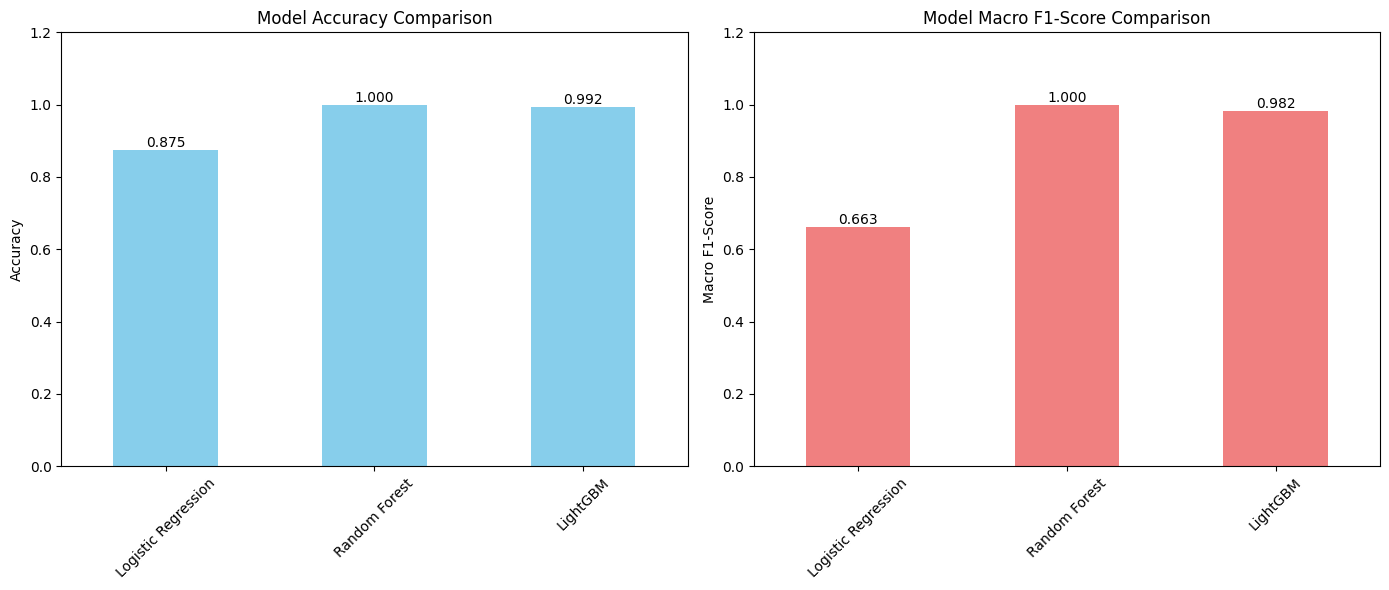


Comparison plots displayed.
Macro F1-Score is used for multi-class classification to average F1-scores of each class.


In [16]:
# Plot the comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

comparison_df['Accuracy'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Model Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylim(0, 1.2) # Assuming accuracy is between 0 and 1
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.3f')


comparison_df['Macro F1-Score'].plot(kind='bar', ax=ax[1], color='lightcoral')
ax[1].set_title('Model Macro F1-Score Comparison')
ax[1].set_ylabel('Macro F1-Score')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylim(0, 1.2) # F1-score is between 0 and 1
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.3f')


plt.tight_layout()
plt.show()

print("\nComparison plots displayed.")
print("Macro F1-Score is used for multi-class classification to average F1-scores of each class.")

In [17]:
import joblib # Import joblib for saving/loading
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

model_filename = 'random_forest_model.joblib'
scaler_filename = 'scaler.joblib'
encoder_filename = 'onehot_encoder.joblib'
feature_list_filename = 'feature_list.joblib'



In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier # Assuming RF is best
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib # Import joblib for saving/loading



# --- 1. Load the dataset ---
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{dataset_path}' was not found. Exiting.")
    exit()

# --- 2. Preprocessing (as before) ---

# Identify features and target
features_list = ['timestamp', 'payload_size', 'payload_is_json', 'payload_has_temp_hum_keys', 'msg_rate_in_window', 'qos', 'retain']
target = 'attack_label'

X = df[features_list].copy() # Use .copy() to avoid SettingWithCopyWarning
y = df[target]

# Convert boolean columns to numeric (0 or 1) before defining transformers
for col in ['payload_is_json', 'payload_has_temp_hum_keys', 'retain']:
    X[col] = X[col].astype(int)

# Define numerical features for scaling
numerical_features_to_scale = ['timestamp', 'payload_size', 'msg_rate_in_window', 'qos', 'payload_is_json', 'payload_has_temp_hum_keys', 'retain']

# Create preprocessing pipelines for numerical features
scaler = StandardScaler()

# Create a column transformer to apply scaling to numerical features
# We are transforming all selected features in this case.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features_to_scale)
    ]
)

# Fit the preprocessor on the entire training data (or relevant portion)
# For consistent preprocessing, fit on the features BEFORE splitting
X_processed_array = preprocessor.fit_transform(X)

# Get the names of the processed features
processed_feature_names = numerical_features_to_scale

# Convert the processed features array back to a DataFrame (useful for inspection, not strictly necessary before splitting)
X_processed_df = pd.DataFrame(X_processed_array, columns=processed_feature_names)

# Encode the target variable ('attack_label') using One-Hot Encoding
# Fit on the whole target variable to ensure all classes are captured
onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded_array = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

# Get the names of the encoded target variable columns
encoded_target_names = onehot_encoder.get_feature_names_out([target])

# Convert the encoded target variable to a DataFrame (useful for inspection)
y_encoded_df = pd.DataFrame(y_encoded_array, columns=encoded_target_names)


print("\nPreprocessing complete.")

# --- 3. Split Data (using the processed X and original y for stratify) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42, stratify=y
)

print("\nData splitting complete.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# --- 4. Train the Best Model (Assuming Random Forest) ---
print("\nTraining Random Forest model...")
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
print("Random Forest training complete.")


# --- 5. Evaluate the Model ---
y_pred = best_model.predict(X_test)
print("\n--- Random Forest Evaluation ---")
print(classification_report(y_test, y_pred, zero_division=0))
print("-" * 30)


# --- 6. Save the Trained Model and Preprocessors ---
model_filename = 'random_forest_model.joblib'
scaler_filename = 'scaler.joblib'
encoder_filename = 'onehot_encoder.joblib'
feature_list_filename = 'feature_list.joblib'

joblib.dump(best_model, model_filename)
joblib.dump(scaler, scaler_filename) # Save the fitted scaler
joblib.dump(onehot_encoder, encoder_filename) # Save the fitted encoder
joblib.dump(features_list, feature_list_filename) # Save the list of feature names

print(f"\nModel saved to {model_filename}")
print(f"Scaler saved to {scaler_filename}")
print(f"Encoder saved to {encoder_filename}")
print(f"Feature list saved to {feature_list_filename}")

Dataset loaded successfully.

Preprocessing complete.

Data splitting complete.
X_train shape: (512, 7), y_train shape: (512,)
X_test shape: (128, 7), y_test shape: (128,)

Training Random Forest model...
Random Forest training complete.

--- Random Forest Evaluation ---
                     precision    recall  f1-score   support

            DOS_PUB       1.00      1.00      1.00         6
INVALID_PAYLOAD_PUB       1.00      1.00      1.00         8
             NORMAL       1.00      1.00      1.00        85
   UNAUTHORIZED_PUB       1.00      1.00      1.00        29

           accuracy                           1.00       128
          macro avg       1.00      1.00      1.00       128
       weighted avg       1.00      1.00      1.00       128

------------------------------

Model saved to random_forest_model.joblib
Scaler saved to scaler.joblib
Encoder saved to onehot_encoder.joblib
Feature list saved to feature_list.joblib


--- Loading Data ---
Dataset loaded successfully. Head:
      timestamp event_source   client_id                                topic  \
0  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   
1  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   
2  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   
3  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   
4  1.745412e+09     observer  sensor_001  iot/simulation/data/sensor_001/data   

   qos  retain  payload_size  payload_is_json  payload_has_temp_hum_keys  \
0    0   False            93             True                       True   
1    0   False            93             True                       True   
2    0   False            93             True                       True   
3    0   False            92             True                       True   
4    0   False            93             True                       True   



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating Random Forest...
--- Random Forest Classification Report ---
                     precision    recall  f1-score   support

            DOS_PUB       1.00      1.00      1.00         6
INVALID_PAYLOAD_PUB       1.00      1.00      1.00         8
             NORMAL       1.00      1.00      1.00        85
   UNAUTHORIZED_PUB       1.00      1.00      1.00        29

           accuracy                           1.00       128
          macro avg       1.00      1.00      1.00       128
       weighted avg       1.00      1.00      1.00       128

-----------------------------------------

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 5
[LightGBM] [Info] Start training from score -3.060271
[LightGBM] [Info] Start training f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


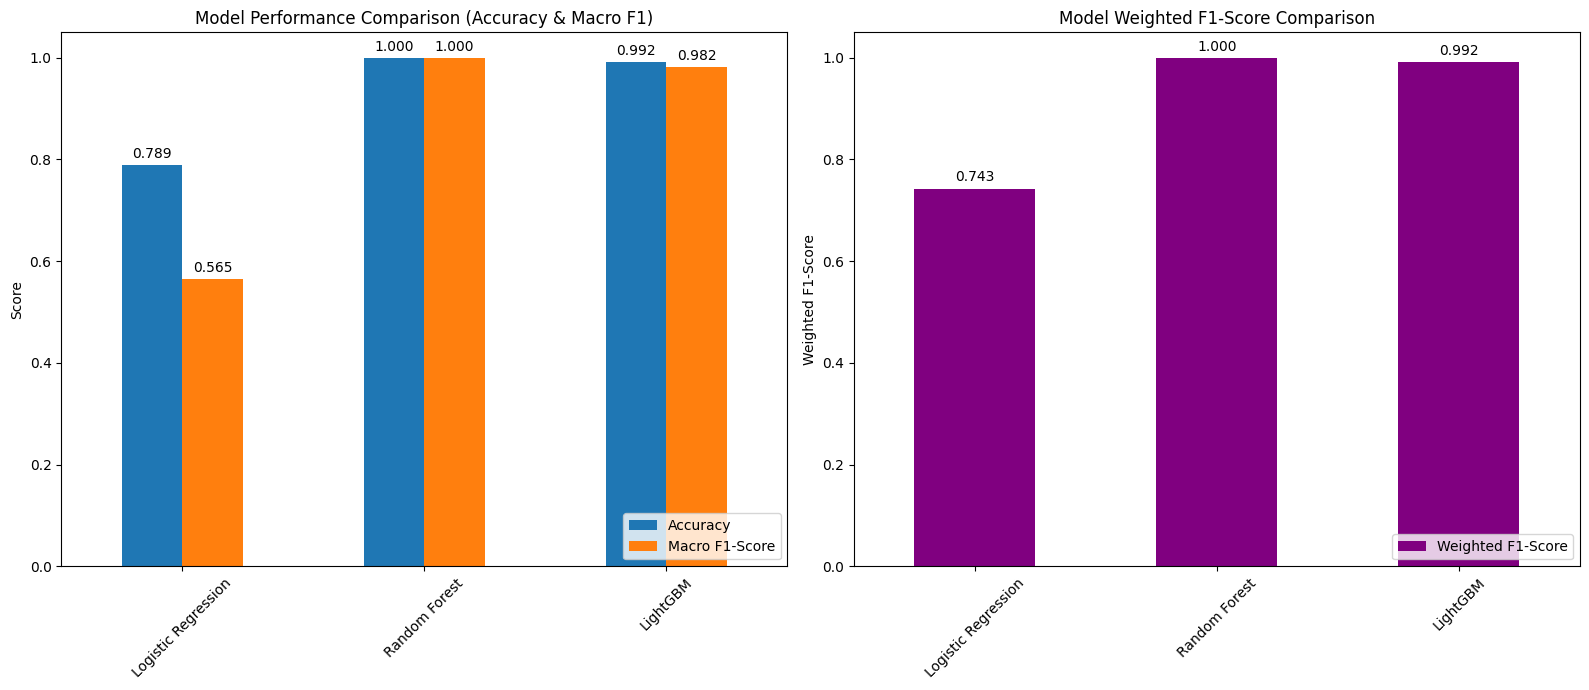


Comparison plots displayed.
Macro F1-Score is useful when classes have similar importance.
Weighted F1-Score is useful when accounting for class imbalance (weighted by class support).

--- Saving Best Model and Preprocessors ---
Best model based on Macro F1-Score: Random Forest
Best model saved to best_model.joblib
Fitted preprocessor saved to fitted_preprocessor.joblib
Fitted OneHotEncoder saved to fitted_onehot_encoder.joblib
Feature list saved to feature_list.joblib

--- Part 2: Loading Saved Models and Predicting with Random Data ---
Loading saved model, preprocessor, encoder, and feature list...
Components loaded successfully.

Generating random input data...

Generated random inputs:
    timestamp  payload_size  payload_is_json  payload_has_temp_hum_keys  \
0  1725137900           106                0                          1   
1  1717801383           369                0                          0   
2  1739926623           176                0                          0   


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [27]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Although we won't use a Pipeline for model training after preprocessing here, it's good practice
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import lightgbm as lgb # Make sure lightgbm is installed (pip install lightgbm)
from sklearn.exceptions import NotFittedError # Import for potential error handling

# --- Configuration ---
dataset_path = '/content/iot_traffic_log.csv'
# Define file paths for saving models and preprocessors
MODEL_FILE = 'best_model.joblib'
PREPROCESSOR_FILE = 'fitted_preprocessor.joblib'
ENCODER_FILE = 'fitted_onehot_encoder.joblib'
FEATURE_LIST_FILE = 'feature_list.joblib'


# --- Part 1: Training and Evaluation ---

# --- 1. Load the dataset ---
print("--- Loading Data ---")
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully. Head:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nValue counts for target variable:")
    print(df['attack_label'].value_counts())
except FileNotFoundError:
    print(f"Error: The file '{dataset_path}' was not found. Please check the path.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit()


# --- 2. Feature Selection ---
print("\n--- Feature Selection ---")
# We'll select numerical and boolean features that seem relevant.
# Exclude high-cardinality or text features for this approach.
# Based on the head provided previously:
features_list = [
    'timestamp',
    'payload_size',
    'payload_is_json',
    'payload_has_temp_hum_keys',
    'msg_rate_in_window',
    'qos',
    'retain'
]
target = 'attack_label'

# Ensure all selected features are in the DataFrame
if not all(feature in df.columns for feature in features_list):
    missing_features = [feature for feature in features_list if feature not in df.columns]
    print(f"Error: Missing features in the dataset: {missing_features}")
    # Attempt to proceed with available features, or exit
    features_list = [feature for feature in features_list if feature in df.columns]
    if not features_list:
         print("No valid features remaining after checking. Exiting.")
         exit()
    print(f"Proceeding with available features: {features_list}")


X = df[features_list].copy()
y = df[target].copy()

print(f"Selected features ({len(features_list)}): {features_list}")
print(f"Target variable: {target}")


# --- 3. Preprocessing ---
print("\n--- Preprocessing ---")

# Convert boolean columns to numeric (0 or 1) before splitting
# This is done directly on X before the split
for col in ['payload_is_json', 'payload_has_temp_hum_keys', 'retain']:
    if col in X.columns:
        X[col] = X[col].astype(int)
        print(f"Converted '{col}' to int.")
    else:
         print(f"Warning: Boolean feature '{col}' not found in dataset.")


# --- 4. Split Data ---
# Split data BEFORE fitting preprocessors to prevent data leakage
print("\n--- Splitting Data ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Stratify to maintain class distribution
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


# Define numerical features for scaling (these are the ones the scaler acts on)
# After converting booleans to int, all selected features are numerical
numerical_features_to_scale = features_list

# Create the scaler
scaler = StandardScaler()

# Create a column transformer to apply scaling to the defined numerical features
# All selected features are transformed here.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features_to_scale)
    ],
    remainder='passthrough' # Pass through any columns not specified (none in this case)
)

# Fit the preprocessor ONLY on the training data
print("Fitting preprocessor on training data...")
preprocessor.fit(X_train)

# Transform both training and testing data using the fitted preprocessor
print("Transforming training and testing data...")
X_train_scaled = preprocessor.transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Convert transformed arrays back to DataFrames (optional but helpful)
# The column names after transformation by ColumnTransformer are accessible via get_feature_names_out
# However, since we only have one transformer ('num') acting on all columns,
# the output array columns correspond directly to the input columns in numerical_features_to_scale
# and in the original features_list.
transformed_feature_names = numerical_features_to_scale # Get names from preprocessor if complex

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=transformed_feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=transformed_feature_names)


# Encode the target variable ('attack_label') using One-Hot Encoding
# Fit on the *entire* target variable 'y' to ensure all possible classes are known
print("Fitting OneHotEncoder on full target variable...")
onehot_encoder = OneHotEncoder(sparse_output=False)
# Fit and transform y_train. Fit on y *before* splitting to learn all classes.
onehot_encoder.fit(y.values.reshape(-1, 1)) # Fit on full y to know all classes

# Transform y_train and y_test
y_train_encoded = onehot_encoder.transform(y_train.values.reshape(-1, 1))
y_test_encoded = onehot_encoder.transform(y_test.values.reshape(-1, 1))

# Get encoded target names (e.g., attack_label_NORMAL, attack_label_DoS)
encoded_target_names = onehot_encoder.get_feature_names_out([target])

print("\nPreprocessing complete.")
print("Head of scaled training features:")
print(pd.DataFrame(X_train_scaled, columns=transformed_feature_names).head())
print("\nHead of encoded training target:")
print(pd.DataFrame(y_train_encoded, columns=encoded_target_names).head())


# --- 5. Train Models ---
print("\n--- Training Models ---")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='auto', solver='liblinear'), # Specify multi_class and solver
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

trained_models = {}
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    try:
        # Train the model on the scaled training data and original target labels
        model.fit(X_train_scaled, y_train)
        trained_models[model_name] = model # Store the trained model

        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test_scaled)

        # Get evaluation metrics using the original y_test labels
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        results[model_name] = {
            'accuracy': accuracy,
            'report': report,
            'f1_score_macro': report['macro avg']['f1-score'], # Use macro average F1-score
            'f1_score_weighted': report['weighted avg']['f1-score'] # Use weighted average F1-score
        }

        print(f"--- {model_name} Classification Report ---")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("-" * (len(model_name) + 28))

    except Exception as e:
        print(f"An error occurred during training or evaluation of {model_name}: {e}")
        results[model_name] = {'error': str(e)}


# --- 6. Compare and Plot Results ---
print("\n--- Model Comparison ---")

# Create a DataFrame for easier comparison
comparison_data = {}
for name, res in results.items():
    if 'error' not in res:
        comparison_data[name] = {'Accuracy': res['accuracy'],
                                 'Macro F1-Score': res['f1_score_macro'],
                                 'Weighted F1-Score': res['f1_score_weighted']}
    else:
         comparison_data[name] = {'Accuracy': np.nan, 'Macro F1-Score': np.nan, 'Weighted F1-Score': np.nan, 'Error': res['error']}


comparison_df = pd.DataFrame(comparison_data).T # Transpose to have models as rows

print(comparison_df)

# Plot the comparison (only for models without errors)
comparison_df_plot = comparison_df.dropna(subset=['Accuracy']) # Only plot if accuracy is available

if not comparison_df_plot.empty:
    fig, ax = plt.subplots(1, 2, figsize=(16, 7)) # Increased figure size

    comparison_df_plot[['Accuracy', 'Macro F1-Score']].plot(kind='bar', ax=ax[0]) # Plot Accuracy and Macro F1 together
    ax[0].set_title('Model Performance Comparison (Accuracy & Macro F1)')
    ax[0].set_ylabel('Score')
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].set_ylim(0, 1.05) # Allow a little space above 1 for labels
    ax[0].legend(loc='lower right')
    # Add value labels
    for container in ax[0].containers:
        ax[0].bar_label(container, fmt='%.3f', padding=3)


    comparison_df_plot[['Weighted F1-Score']].plot(kind='bar', ax=ax[1], color='purple') # Plot Weighted F1 separately
    ax[1].set_title('Model Weighted F1-Score Comparison')
    ax[1].set_ylabel('Weighted F1-Score')
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].set_ylim(0, 1.05)
    ax[1].legend(loc='lower right')
    # Add value labels
    for container in ax[1].containers:
        ax[1].bar_label(container, fmt='%.3f', padding=3)


    plt.tight_layout()
    plt.show()
else:
    print("\nNo models trained successfully to plot results.")

print("\nComparison plots displayed.")
print("Macro F1-Score is useful when classes have similar importance.")
print("Weighted F1-Score is useful when accounting for class imbalance (weighted by class support).")


# --- 7. Save Best Result ---
print("\n--- Saving Best Model and Preprocessors ---")

# Determine the best model based on Macro F1-Score (or choose another metric)
if not comparison_df_plot.empty:
    best_model_name = comparison_df_plot['Macro F1-Score'].idxmax()
    best_model_trained = trained_models[best_model_name]

    print(f"Best model based on Macro F1-Score: {best_model_name}")

    try:
        # Save the best trained model
        joblib.dump(best_model_trained, MODEL_FILE)
        print(f"Best model saved to {MODEL_FILE}")

        # Save the fitted preprocessor (ColumnTransformer)
        joblib.dump(preprocessor, PREPROCESSOR_FILE)
        print(f"Fitted preprocessor saved to {PREPROCESSOR_FILE}")

        # Save the fitted one-hot encoder
        joblib.dump(onehot_encoder, ENCODER_FILE)
        print(f"Fitted OneHotEncoder saved to {ENCODER_FILE}")

        # Save the list of original feature names
        joblib.dump(features_list, FEATURE_LIST_FILE)
        print(f"Feature list saved to {FEATURE_LIST_FILE}")

    except Exception as e:
        print(f"An error occurred during saving: {e}")
else:
    print("No models were successfully trained, skipping saving.")


# --- Part 2: Loading and Prediction with Random Data ---

print("\n--- Part 2: Loading Saved Models and Predicting with Random Data ---")

# --- 8. Load Saved Components ---
print("Loading saved model, preprocessor, encoder, and feature list...")
try:
    loaded_model = joblib.load(MODEL_FILE)
    loaded_preprocessor = joblib.load(PREPROCESSOR_FILE)
    loaded_encoder = joblib.load(ENCODER_FILE)
    loaded_feature_list = joblib.load(FEATURE_LIST_FILE)
    print("Components loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading saved files for prediction: {e}")
    print("Please ensure the saving step completed successfully.")
    # Set components to None to prevent errors later
    loaded_model = None
    loaded_preprocessor = None
    loaded_encoder = None
    loaded_feature_list = None
except Exception as e:
    print(f"An error occurred during loading for prediction: {e}")
    loaded_model = None
    loaded_preprocessor = None
    loaded_encoder = None
    loaded_feature_list = None


if loaded_model and loaded_preprocessor and loaded_encoder and loaded_feature_list:
    # --- 9. Predict with Random Data ---
    print("\nGenerating random input data...")
    num_random_samples = 5
    random_inputs_list = []

    for i in range(num_random_samples):
        random_input_data = {}
        for feature_name in loaded_feature_list:
            # Generate random data corresponding to each feature type
            if feature_name == 'timestamp':
                random_input_data[feature_name] = np.random.randint(1.7e9, 1.8e9)
            elif feature_name == 'payload_size':
                random_input_data[feature_name] = np.random.randint(50, 500)
            elif feature_name in ['payload_is_json', 'payload_has_temp_hum_keys', 'retain']:
                 random_input_data[feature_name] = np.random.choice([0, 1])
            elif feature_name == 'qos':
                 random_input_data[feature_name] = np.random.choice([0, 1, 2])
            elif feature_name == 'msg_rate_in_window':
                 random_input_data[feature_name] = np.random.randint(1, 100)

        random_inputs_list.append(random_input_data)

    # Convert the list of dictionaries to a pandas DataFrame
    # Ensure column order matches the feature_list used during training/saving
    random_input_df = pd.DataFrame(random_inputs_list, columns=loaded_feature_list)

    print("\nGenerated random inputs:")
    print(random_input_df)

    # --- 10. Preprocess the random inputs using the loaded preprocessor ---
    print("\nPreprocessing random inputs...")
    try:
        # Use the loaded preprocessor to transform the new data
        random_input_processed_array = loaded_preprocessor.transform(random_input_df)

        # Convert processed array back to DataFrame for clarity
        # Column names are the same as original features_list in this simple case
        random_input_processed_df = pd.DataFrame(random_input_processed_array, columns=loaded_feature_list)

        # --- 11. Make predictions ---
        print("Making predictions...")
        predictions_numerical = loaded_model.predict(random_input_processed_df)

        # --- 12. Display Results ---
        print("\n--- Prediction Results for Random Inputs ---")
        results_df = random_input_df.copy() # Start with original random inputs
        results_df['Predicted_Label'] = predictions_numerical # Add prediction column

        print(results_df)

    except NotFittedError:
         print("\nError: Loaded preprocessor is not fitted. This should not happen if saving was correct.")
    except Exception as e:
        print(f"\nAn error occurred during prediction with random data: {e}")

else:
    print("\nSkipping prediction with random data because components could not be loaded.")